In [2]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr

import pandas as pd

In [3]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

In [4]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'all'
master_dir = ''

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.0 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


In [5]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [6]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 200384 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'cell_type', 'Days_since_onset_float', 'leiden_per_cell_type', 'louvain_per_cell_type', 'umap_density_ICU_status', 'louvain_all', 'louvain'
    uns: 'ICU_status_colors', 'cell_type_colors', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

1       2     3      4    \
0                                                                       
Glycolysis / Gluconeogenesis                LDHC     HK3  LDHB   PFKP   
Citrate cycle (TCA cycle)                   DLST    ACO1    CS  IDH3B   
Pentose phosphate pathway                   PFKP   ALDOA  RPIA  ALDOB   
Pentose and glucuronate interconversions  UGT2B4  UGT2A1  XYLB  CRYL1   
Fructose and mannose metabolism              HK3  PFKFB3  PFKP   FCSK   

                                              5       6      7        8    \
0                                                                           
Glycolysis / Gluconeogenesis                ALDOA   ALDOB   ADH6   GAPDHS   
Citrate cycle (TCA cycle)                    ACLY  SUCLG2   DLAT    IDH3A   
Pentose phosphate pathway                    H6PD     RPE  RPEL1  PRPS1L1   
Pentose and glucuronate interconversions  UGT2B17  UGT1A3   UGDH   UGT1A4   
Fructose and mannose metabolism             ALDOA   ALDOB   GFUS     TPI1   

                                             9     10   ...  124  125  126  \
0                                                       ...                  
Glycolysis / Gluconeogenesis                DLAT  PGM1  ...  NaN  NaN  NaN   
Citrate cycle (TCA cycle)                 SUCLA2  PDHB  ...  NaN  NaN  NaN   
Pentose phosphate pathway                   PFKM  RBKS  ...  NaN  NaN  NaN   
Pentose and glucuronate interconversions  UGT1A8  UGP2  ...  NaN  NaN  NaN   
Fructose and mannose metabolism             PMM2  SORD  ...  NaN  NaN  NaN   

                                          127  128  129  130  131  132  133  
0                                                                            
Glycolysis / Gluconeogenesis              NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Citrate cycle (TCA cycle)                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose phosphate pathway                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose and glucuronate interconversions  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Fructose and mannose metabolism           NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 133 columns]

In [8]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [9]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

2385

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [10]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [11]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
        
    mel = np.zeros([len(cluster_ids), len(data_metab.X[0])])
    for i, cluster_id in enumerate(cluster_ids):
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel[i] = np.sum(g, axis=0) / n # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p

### Making patient pseudobulk 

In [22]:
cluster_ids = list(adata_metab.obs['patient'].unique())
cluster_ids.sort()
totals = np.zeros([len(cluster_ids), len(adata_metab.X[0])])
for i, pt in enumerate(cluster_ids):
    cluster = adata_metab[adata_metab.obs['patient']==pt]
    g = cluster.X
    totals[i] = np.sum(g, axis=0)
totals = pd.DataFrame(totals, columns=adata_metab.var_names)
totals.index = cluster_ids
totals.head()

/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


B3GALT6         NADK       PLCH2         ICMT       ACOT7  \
1-1   463.815796  3015.101318  474.731506  1041.021362  572.703735   
1-2   323.156952  2243.336182  293.723328   765.328735  402.643402   
10-1  406.183289  2297.906250  410.935944  1244.127686  701.507080   
10-2  200.571472  1348.981567  185.259872   537.935242  247.190018   
11-1  195.249939  1521.755249  106.349770   378.529572  115.664894   

              ENO1        CA6         H6PD       PIK3CD      NMNAT1  ...  \
1-1   19074.033203  65.374306  1039.448242  4094.986572  618.089233  ...   
1-2   12203.001953  33.444592   714.093323  2704.699707  411.406769  ...   
10-1  18621.957031  63.844475   986.948608  3642.046387  551.387024  ...   
10-2   7767.152344  19.710808   486.049408  1860.586792  264.508728  ...   
11-1   7319.729492  19.088917   405.521301  1431.285889  231.498810  ...   

             CBR1        CBR3         PIGP       PDE9A       NDUFV3  \
1-1   3216.074219  942.945435  2829.342285  307.412079  3829.736572   
1-2   2293.852051  535.128174  1797.147705  161.314499  2556.974365   
10-1  3255.762939  780.133423  2633.807861  235.007324  3649.046387   
10-2  1381.384277  327.371460  1126.491089   97.666237  1792.000854   
11-1  1479.011719  336.989380   909.257080   71.368752  1827.089111   

             PDXK       AGPAT3         PFKL       POFUT2         LSS  
1-1   2052.107666  1491.830444  6363.420410  1302.348022  732.931152  
1-2   1452.863525  1087.259399  4380.750488   903.242920  479.807404  
10-1  1467.869629  1120.239990  6105.995117  1129.047119  774.429688  
10-2   848.368652   635.358948  2659.158203   542.418335  336.383820  
11-1   885.031616   693.716858  2486.485840   406.484711  229.200439  

[5 rows x 1387 columns]

In [23]:
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
totals = totals.loc[patients_WHO]
totals = totals.transpose()

adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

metab_gene_corr = totals.apply(lambda col: spearmanr(col, 
                            adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], axis=1)
metab_gene_pvalues = totals.apply(lambda col: spearmanr(col, 
                            adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], axis=1)

sig_metab_genes = pd.DataFrame([metab_gene_corr, metab_gene_pvalues]).transpose()
sig_metab_genes = sig_metab_genes[sig_metab_genes.loc[:, 1]<0.05]
sig_metab_genes.columns = ['Spearman', 'p-value']
sig_metab_genes['Spearman_abs'] = abs(sig_metab_genes['Spearman'])
sig_metab_genes['-log10(p)'] = -np.log10(sig_metab_genes['p-value'])
sig_metab_genes = sig_metab_genes.sort_values(by='Spearman_abs', ascending=False)
pd.DataFrame(sig_metab_genes).to_csv(master_dir + 'output/metab_gene-correlations' + 
                                 celltype + '-all_cells' + '.csv')

In [24]:
sig_metab_genes.head()

Spearman       p-value  Spearman_abs  -log10(p)
CYP19A1  0.701787  1.684630e-09      0.701787   8.773496
ACOX2    0.631817  1.770027e-07      0.631817   6.752020
ASS1     0.612194  5.340547e-07      0.612194   6.272414
MPO      0.570615  4.398378e-06      0.570615   5.356707
CES1     0.568667  4.821380e-06      0.568667   5.316829

## Pathway activity analysis between cell types

In [13]:
p = pathway_activity(adata, adata_metab, 'cell_type', print_labels=True)

b_wo_patient4
cd4
cd8
mono
nk


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [14]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
adata.obs['cell_type_shuffle'] = pd.Series()
adata_metab.obs['cell_type_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(adata.obs))
p_shuffle = np.zeros([len(w), len(adata.obs['cell_type'].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['cell_type'])
    adata.obs['cell_type_shuffle'] = clusters_shuffled
    adata_metab.obs['cell_type_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'cell_type_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

<ipython-input-14-60bcd1ffca38>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata.obs['cell_type_shuffle'] = pd.Series()
<ipython-input-14-60bcd1ffca38>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata_metab.obs['cell_type_shuffle'] = pd.Series()


0
100
200
300
400
500
600
700
800
900


In [15]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [16]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                   sep='\t', header=None)
df_p.head()

0         1         2         3         4
0  1.039596  1.000000  0.940269  0.884181  1.000000
1  1.000000  1.000000  1.050932  0.984241  0.969140
2  0.958126  0.819514  0.842116  1.105594  1.028060
3  0.913056  1.033229  0.962622  1.060833  0.931306
4  0.968752  0.939279  0.890309  0.965570  0.816823

<ipython-input-21-59563205a686>:5: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(3, 10))


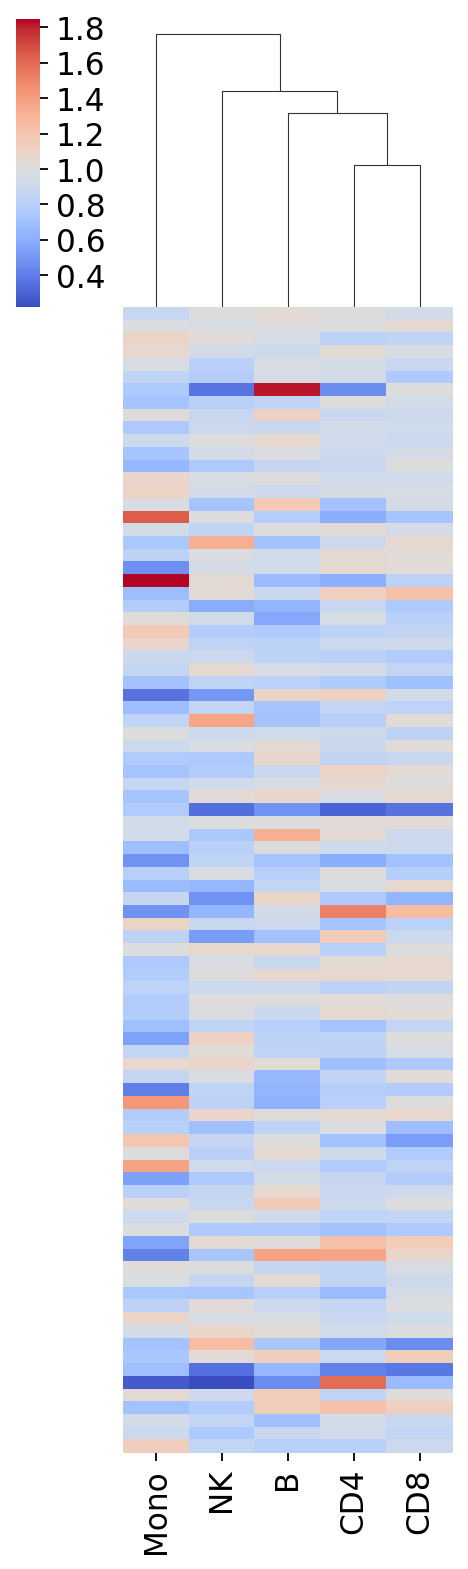

In [21]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='coolwarm', xticklabels=['B', 'CD4', 'CD8', 'Mono', 'NK'], 
                     yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(3, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [22]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

## Pathway activity based on treatment status


In [22]:
adata.obs['no_IL6i_time'] = adata.obs['no_IL6i'].astype(str) + '.' + adata.obs['Blood_draw_time'].astype(str)

In [23]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
p = pathway_activity(adata, adata_metab, 'no_IL6i_time', print_labels=True)

Healthy.Healthy
after.T2
before.T1
no.T1
no.T2


In [13]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['no_IL6i_time'])
    adata.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    adata_metab.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'no_IL6i_time_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [56]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-no_IL6i-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

<ipython-input-24-9ec73cca64d0>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))


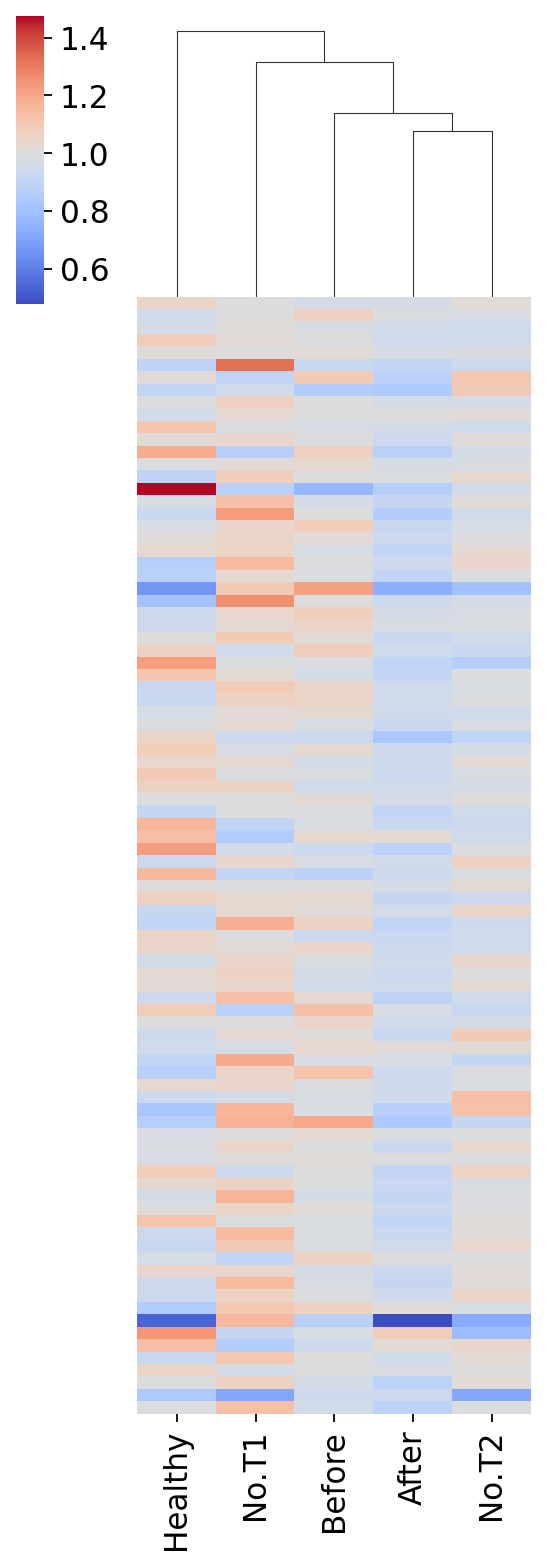

In [24]:
# Heatmap of pathway activities
#fig = plt.figure(figsize=(15, 20))
p_sig_reorder = p[:, [0, 2, 1, 3, 4]]
fig = sns.clustermap(p_sig_reorder, cmap='coolwarm', yticklabels=[], #metab_genes.index, 
                     xticklabels=['Healthy', 'Before', 'After', 'No.T1', 'No.T2'], 
                     row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Excluding the "before" and "no" states of IL6i treatment

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
data = adata[adata.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
data_metab = adata_metab[adata_metab.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
p = pathway_activity(data, data_metab, 'no_IL6i', print_labels=True)

Healthy
before


In [143]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['no_IL6i'])
    data.obs['no_IL6i_shuffle'] = clusters_shuffled
    data_metab.obs['no_IL6i_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'no_IL6i_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

0


/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


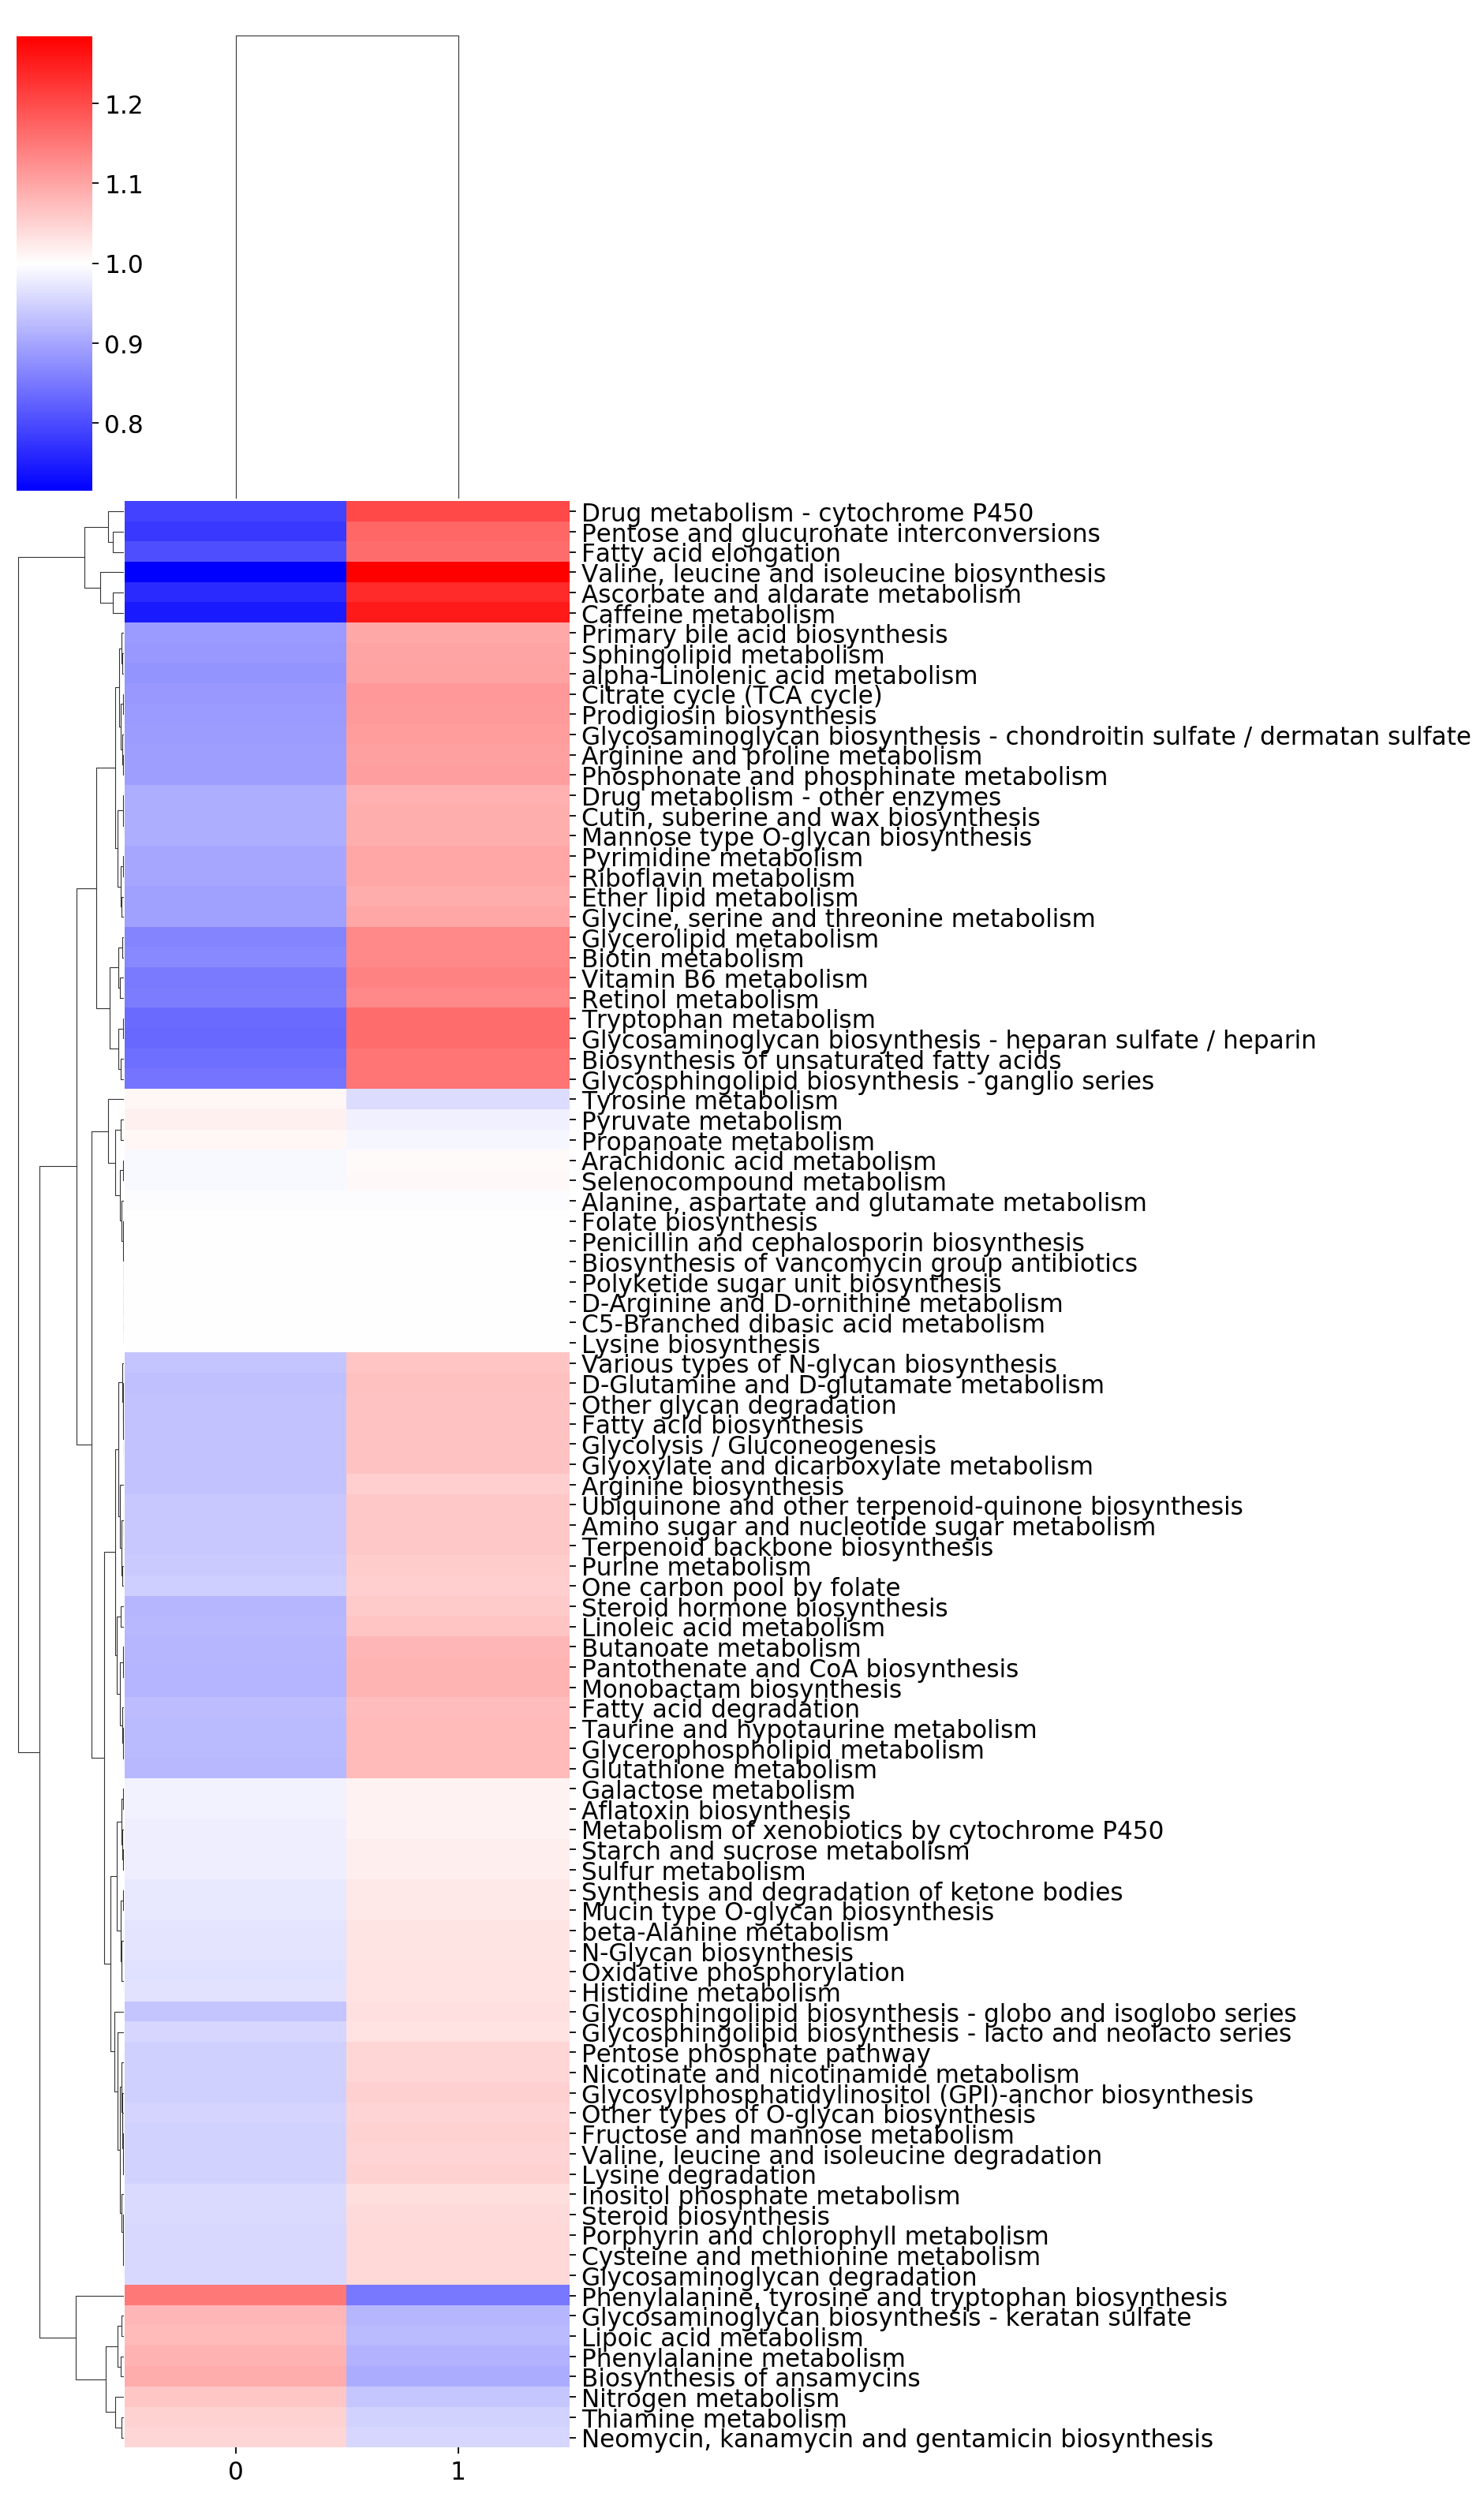

In [49]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
#fig = plt.figure(figsize=(15, 20))
fig = sns.clustermap(p, cmap='bwr', yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), figsize=(12, 20))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Subset analysis (7/3/20)

In [59]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['8', '9'])

0
1
2
3
4
5
6
7


In [60]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'] != '8']
data = data[data.obs['louvain'] != '9']

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [26]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)

# Read previously saved file
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.269933  1.245714  1.161151  1.168757  0.405865  0.391888  1.095304   
1  1.253939  1.188719  1.000000  1.157423  0.385891  0.439595  1.173798   
2  1.332024  1.264875  1.082460  1.286228  0.354537  0.404020  1.163273   
3  1.187085  1.166651  1.000000  1.390074  0.291137  0.380995  1.143976   
4  1.211042  1.285650  1.093694  1.238251  0.644359  0.480916  1.163528   

          7  
0  0.711510  
1  0.836356  
2  0.615205  
3  0.721394  
4  0.852729

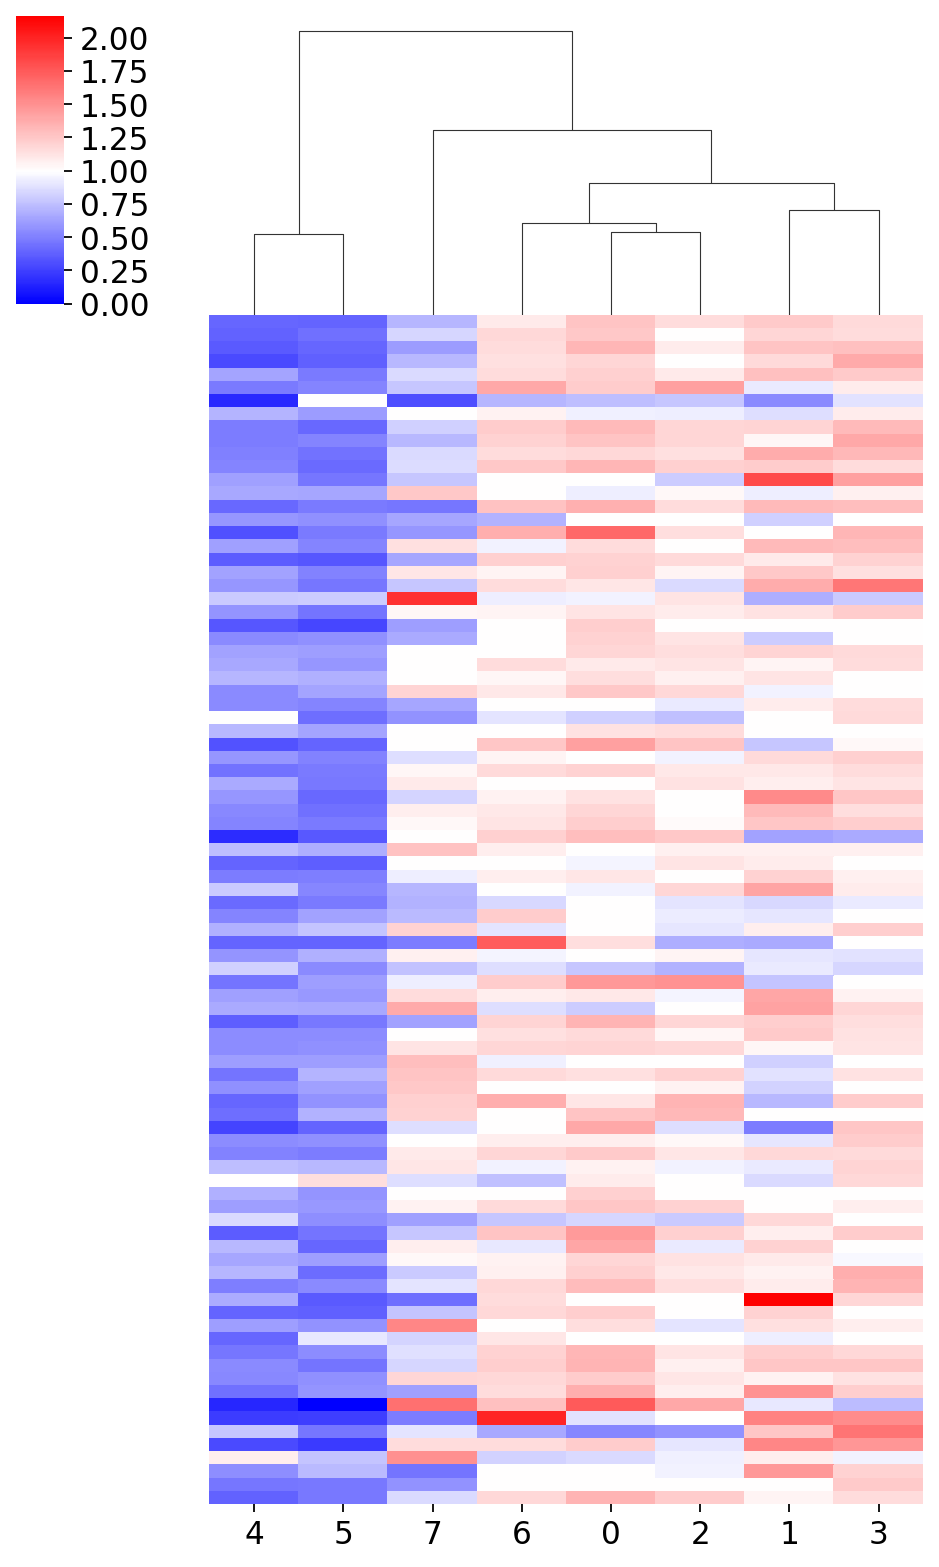

In [27]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False, norm=DivergingNorm(1.0), figsize=(6, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [63]:
# Now without clusters 4, 5, 8, 9
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                    nanval=1)

0
1
2
3
6
7


In [70]:
p_healthy = pathway_activity(adata[adata.obs['WHO_scale']==0], 
                            adata_metab[adata.obs['WHO_scale']==0], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [71]:
p_nonICU = pathway_activity(adata[adata.obs['ICU_status']=='Non-ICU'], 
                            adata_metab[adata.obs['ICU_status']=='Non-ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [72]:
p_ICU = pathway_activity(adata[adata.obs['ICU_status']=='ICU'], 
                            adata_metab[adata.obs['ICU_status']=='ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [66]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'].isin(['0', '1', '2', '3', '6', '7'])]

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [28]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5
0  1.000000  1.000000  1.000000  1.000000  0.921849  0.596736
1  1.000000  1.000000  0.917541  1.000000  1.000000  0.713411
2  1.106028  1.053556  0.904311  1.060293  1.000000  0.495121
3  1.390660  1.000000  0.853480  1.166655  1.000000  0.649370
4  1.058167  1.114285  0.963604  1.076078  1.000000  0.742756

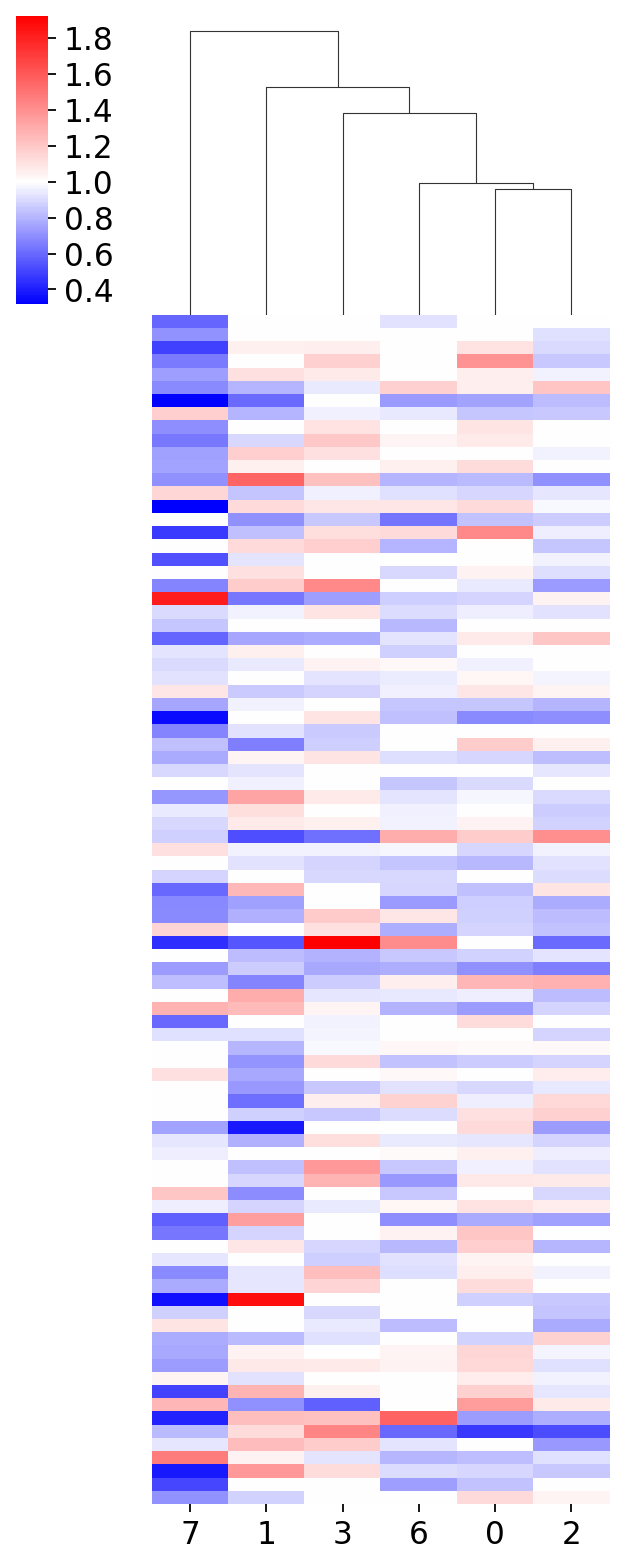

In [30]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], 
                     norm=DivergingNorm(1.0), figsize=(4, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

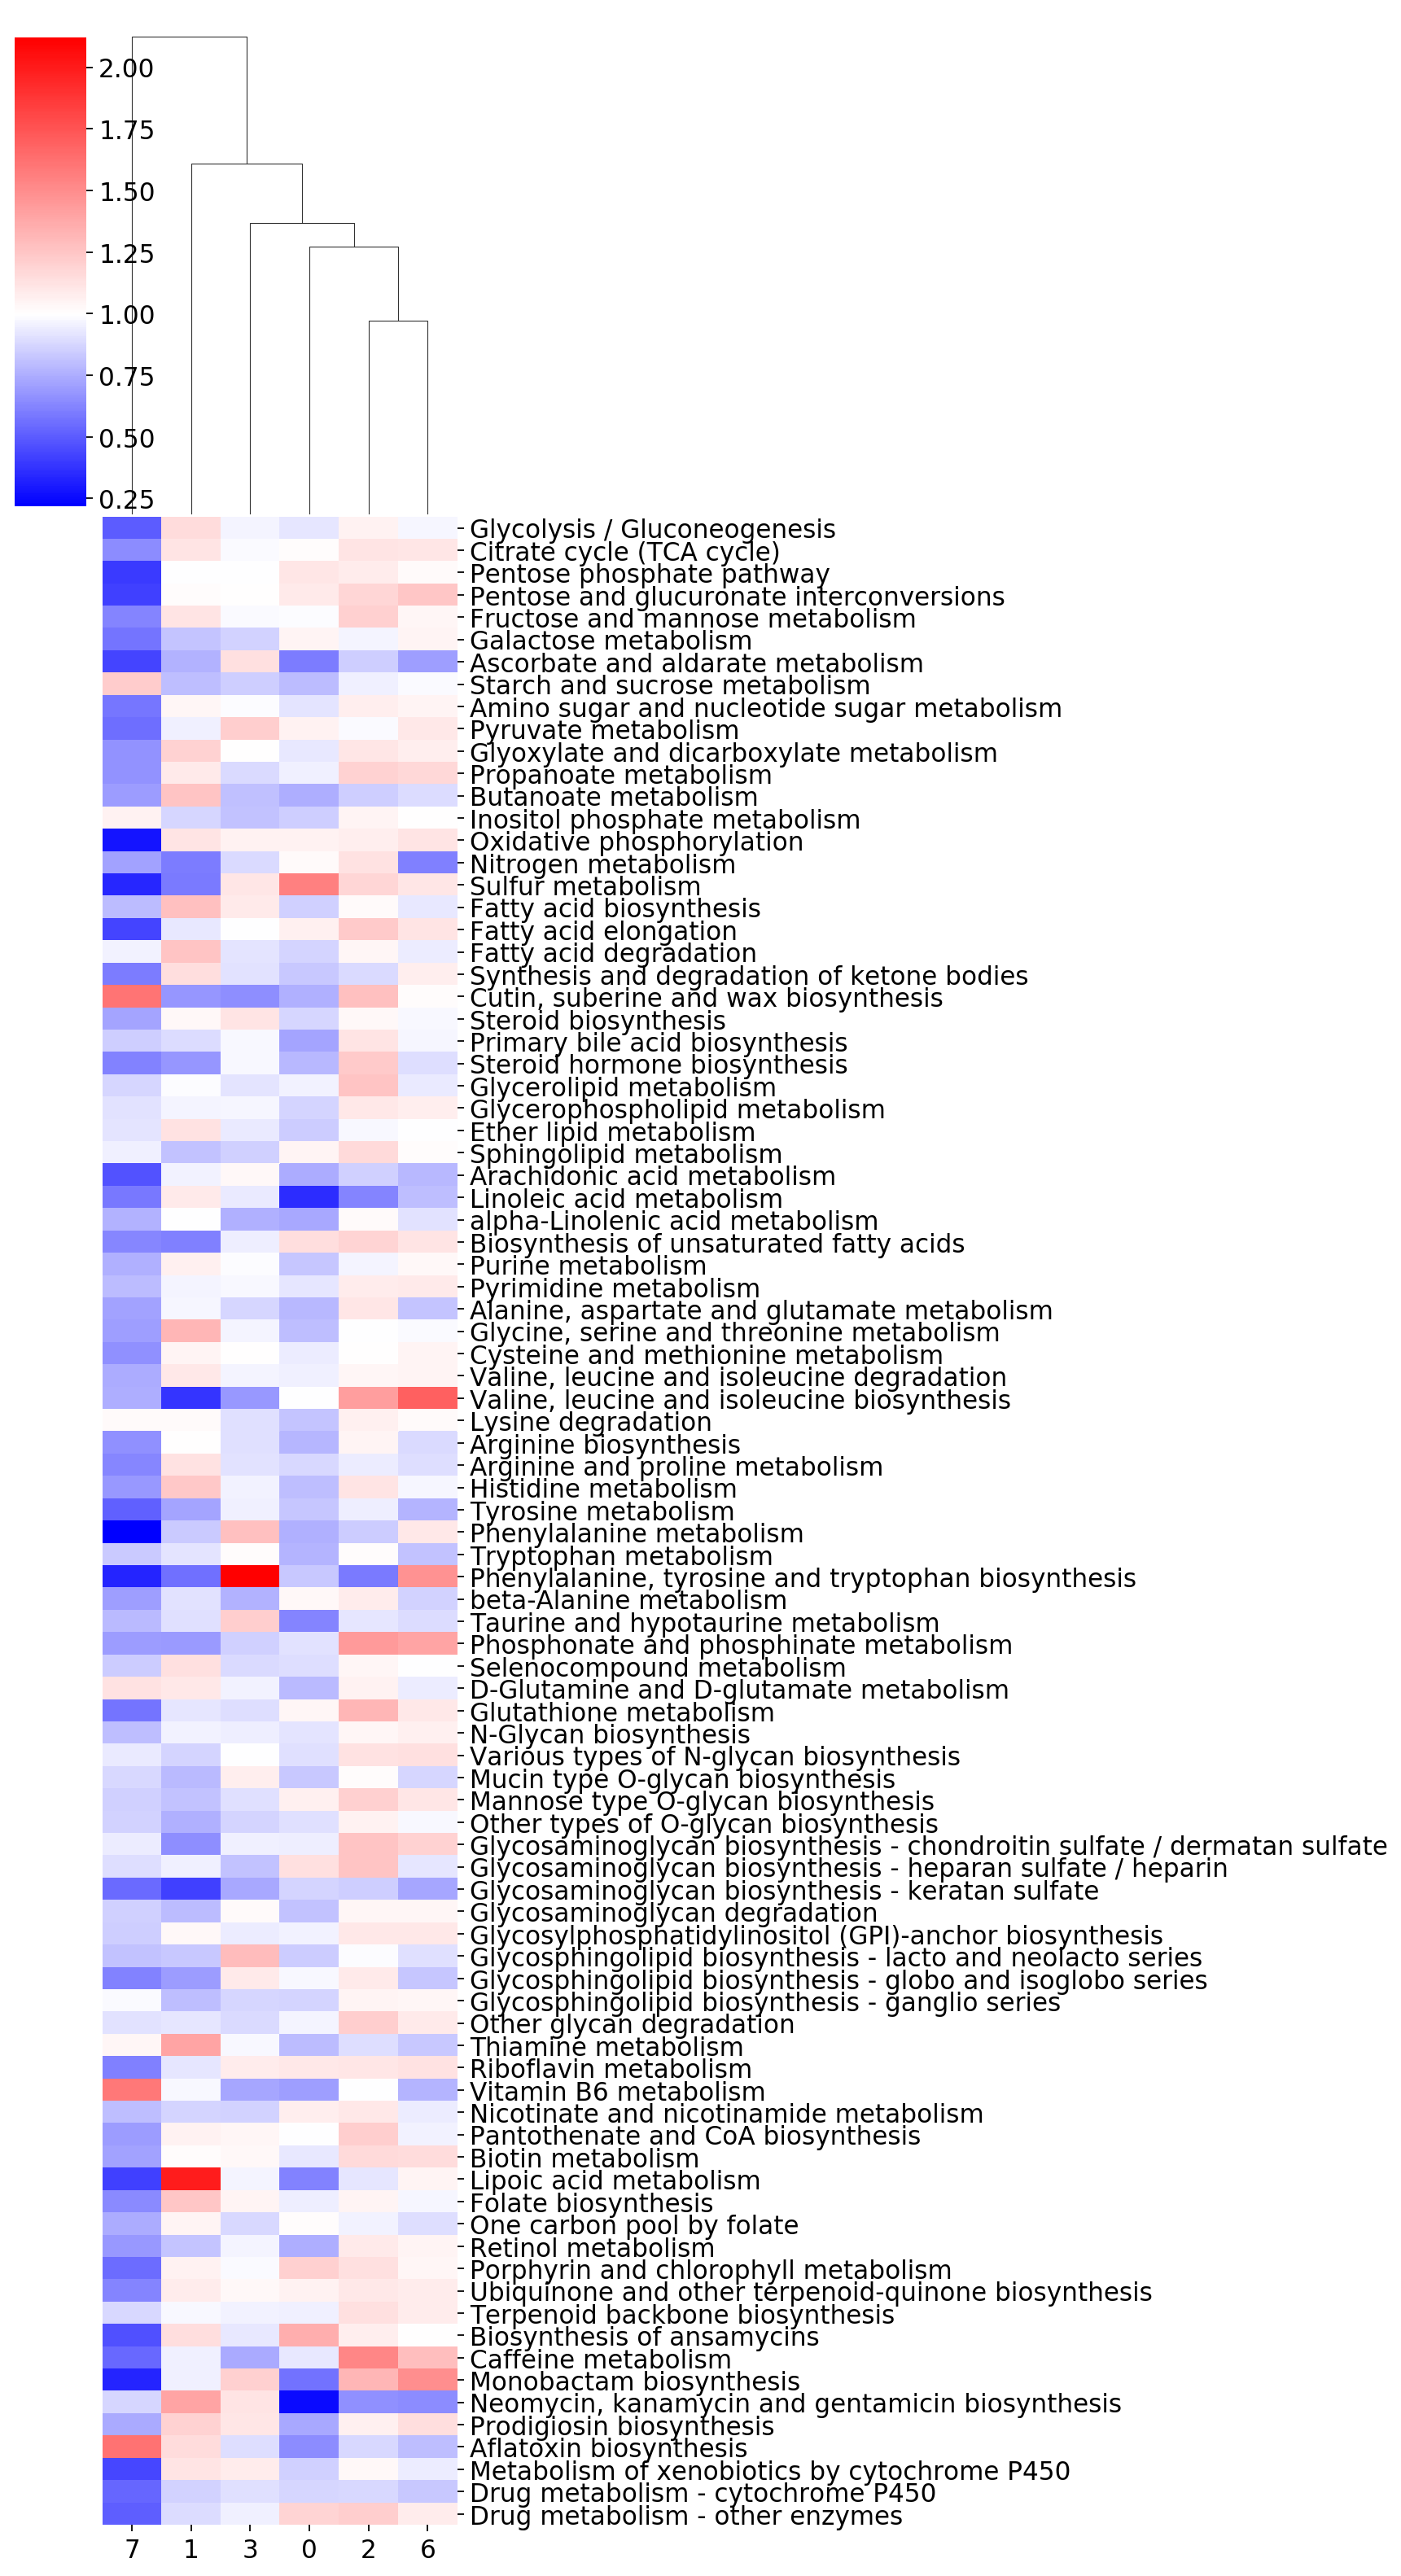

In [73]:
fig = sns.clustermap(p_healthy, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [74]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_healthy)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-healthy-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

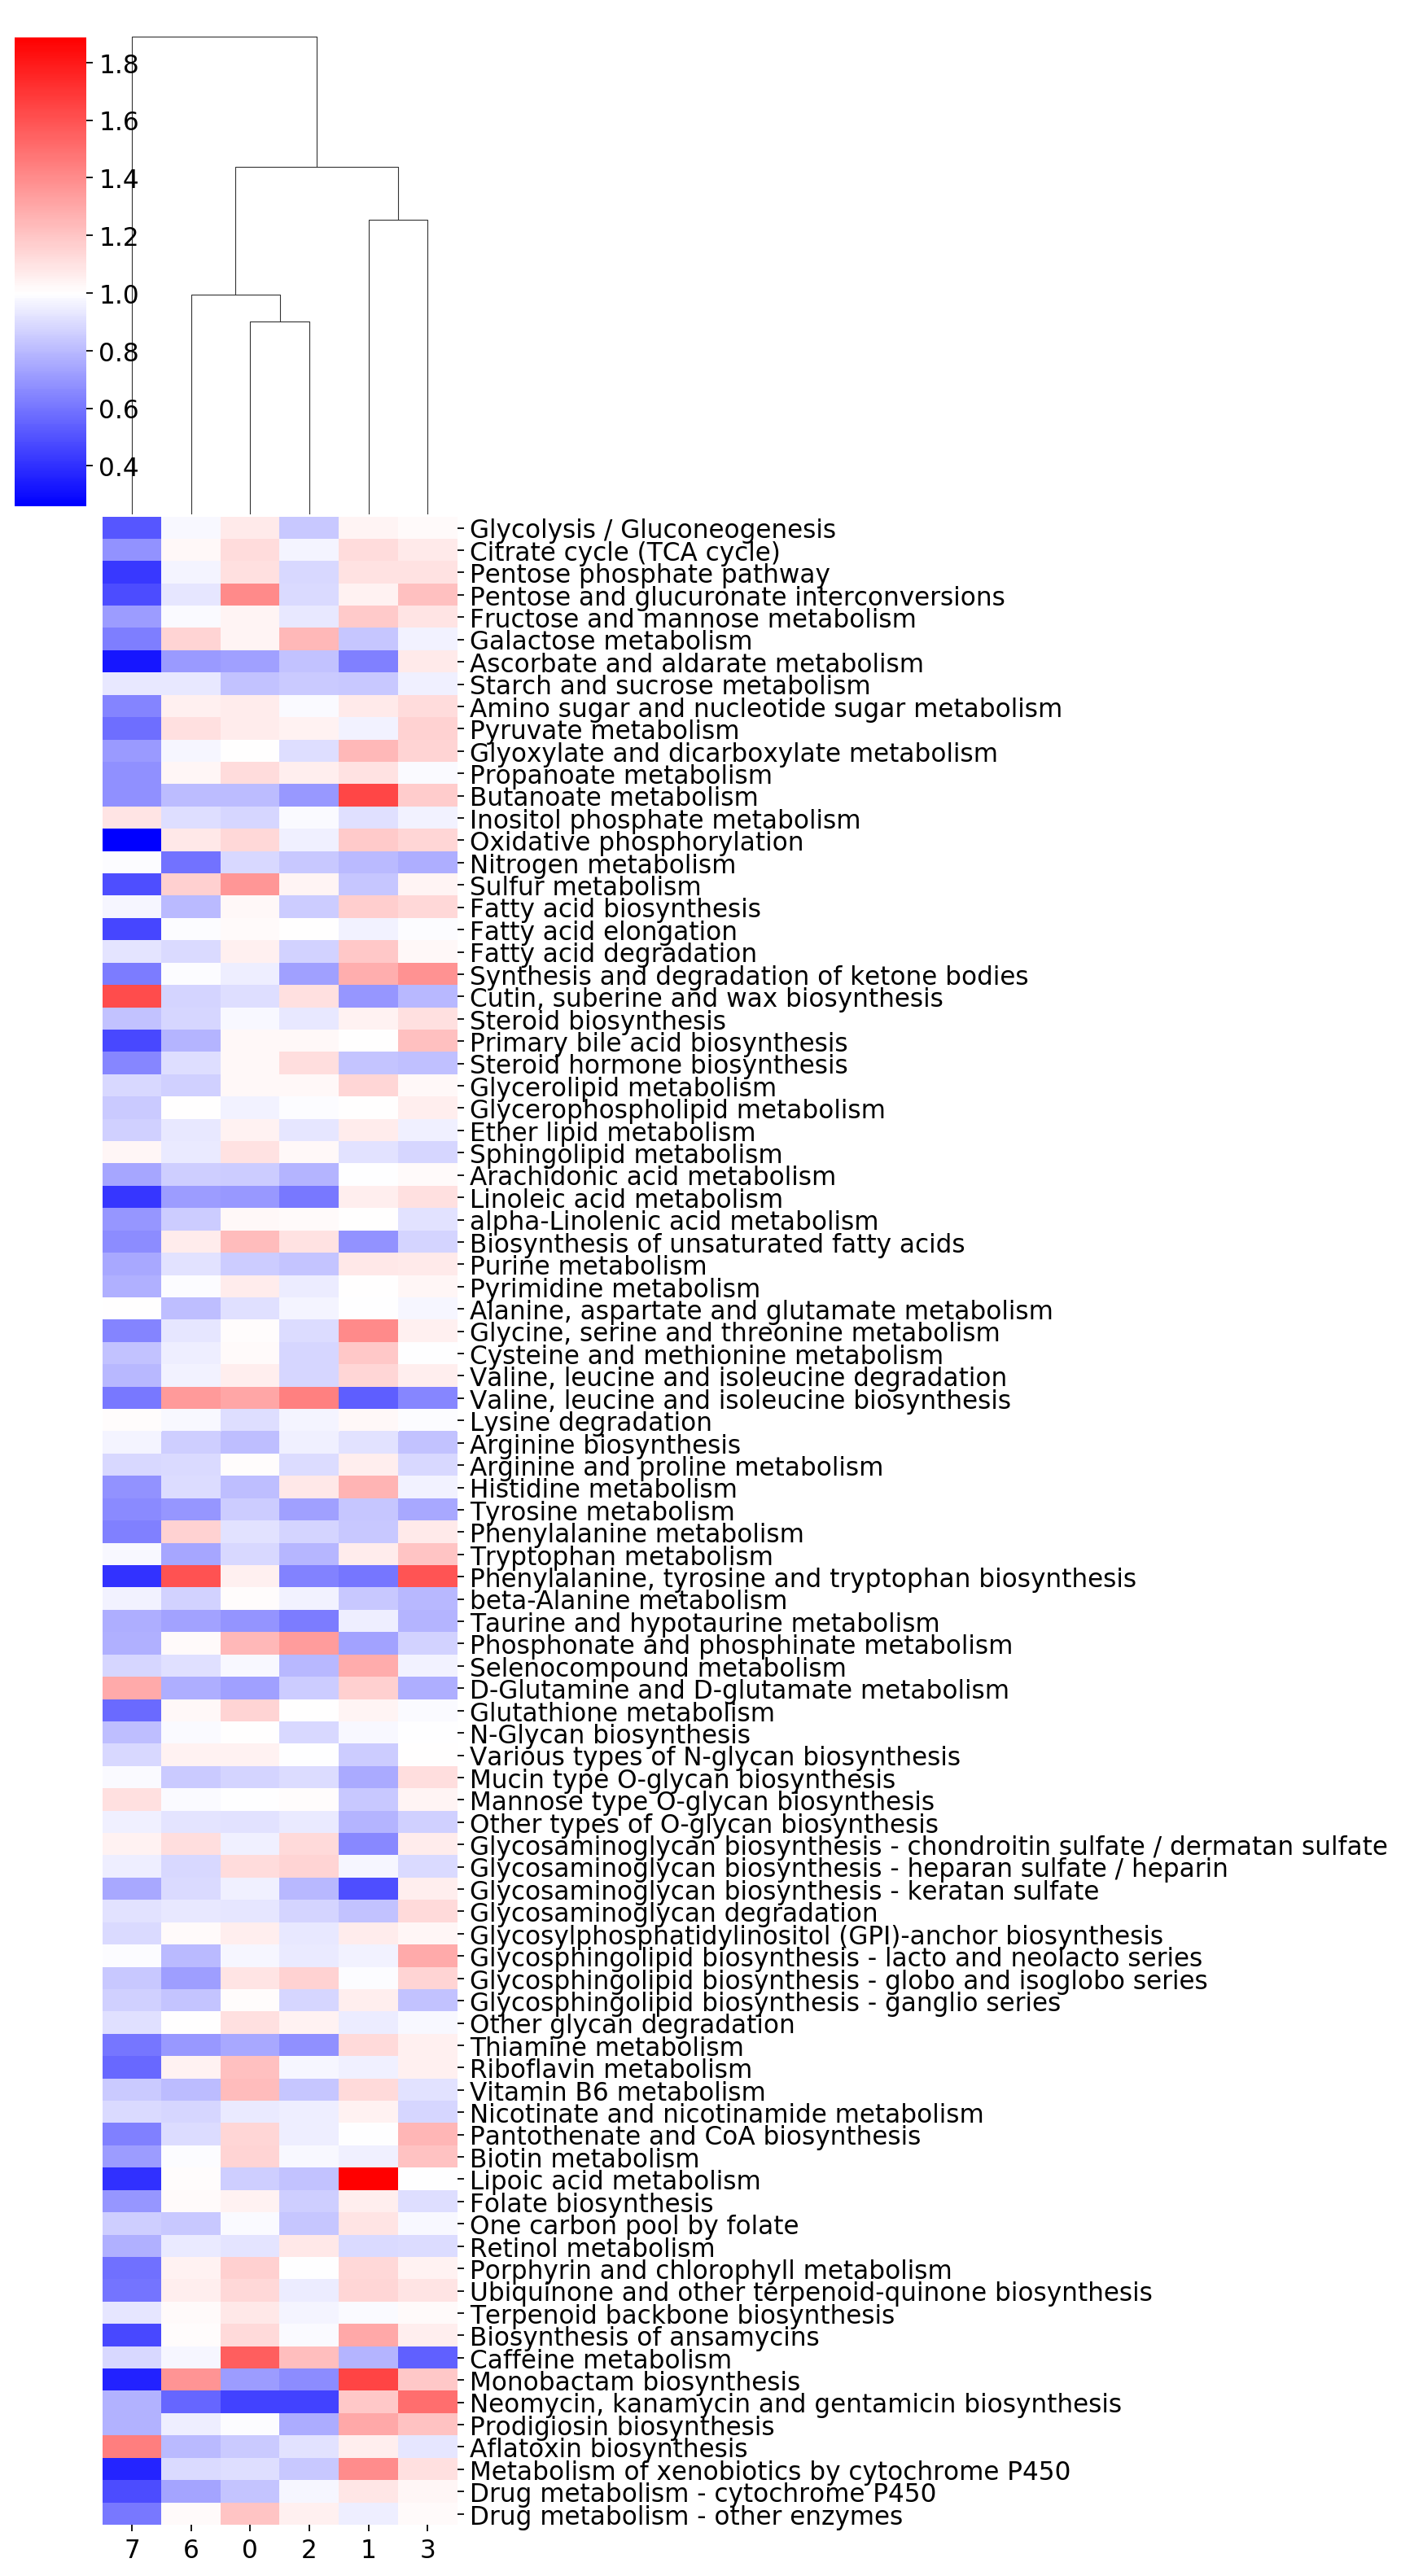

In [75]:
fig = sns.clustermap(p_nonICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [76]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_nonICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-nonICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

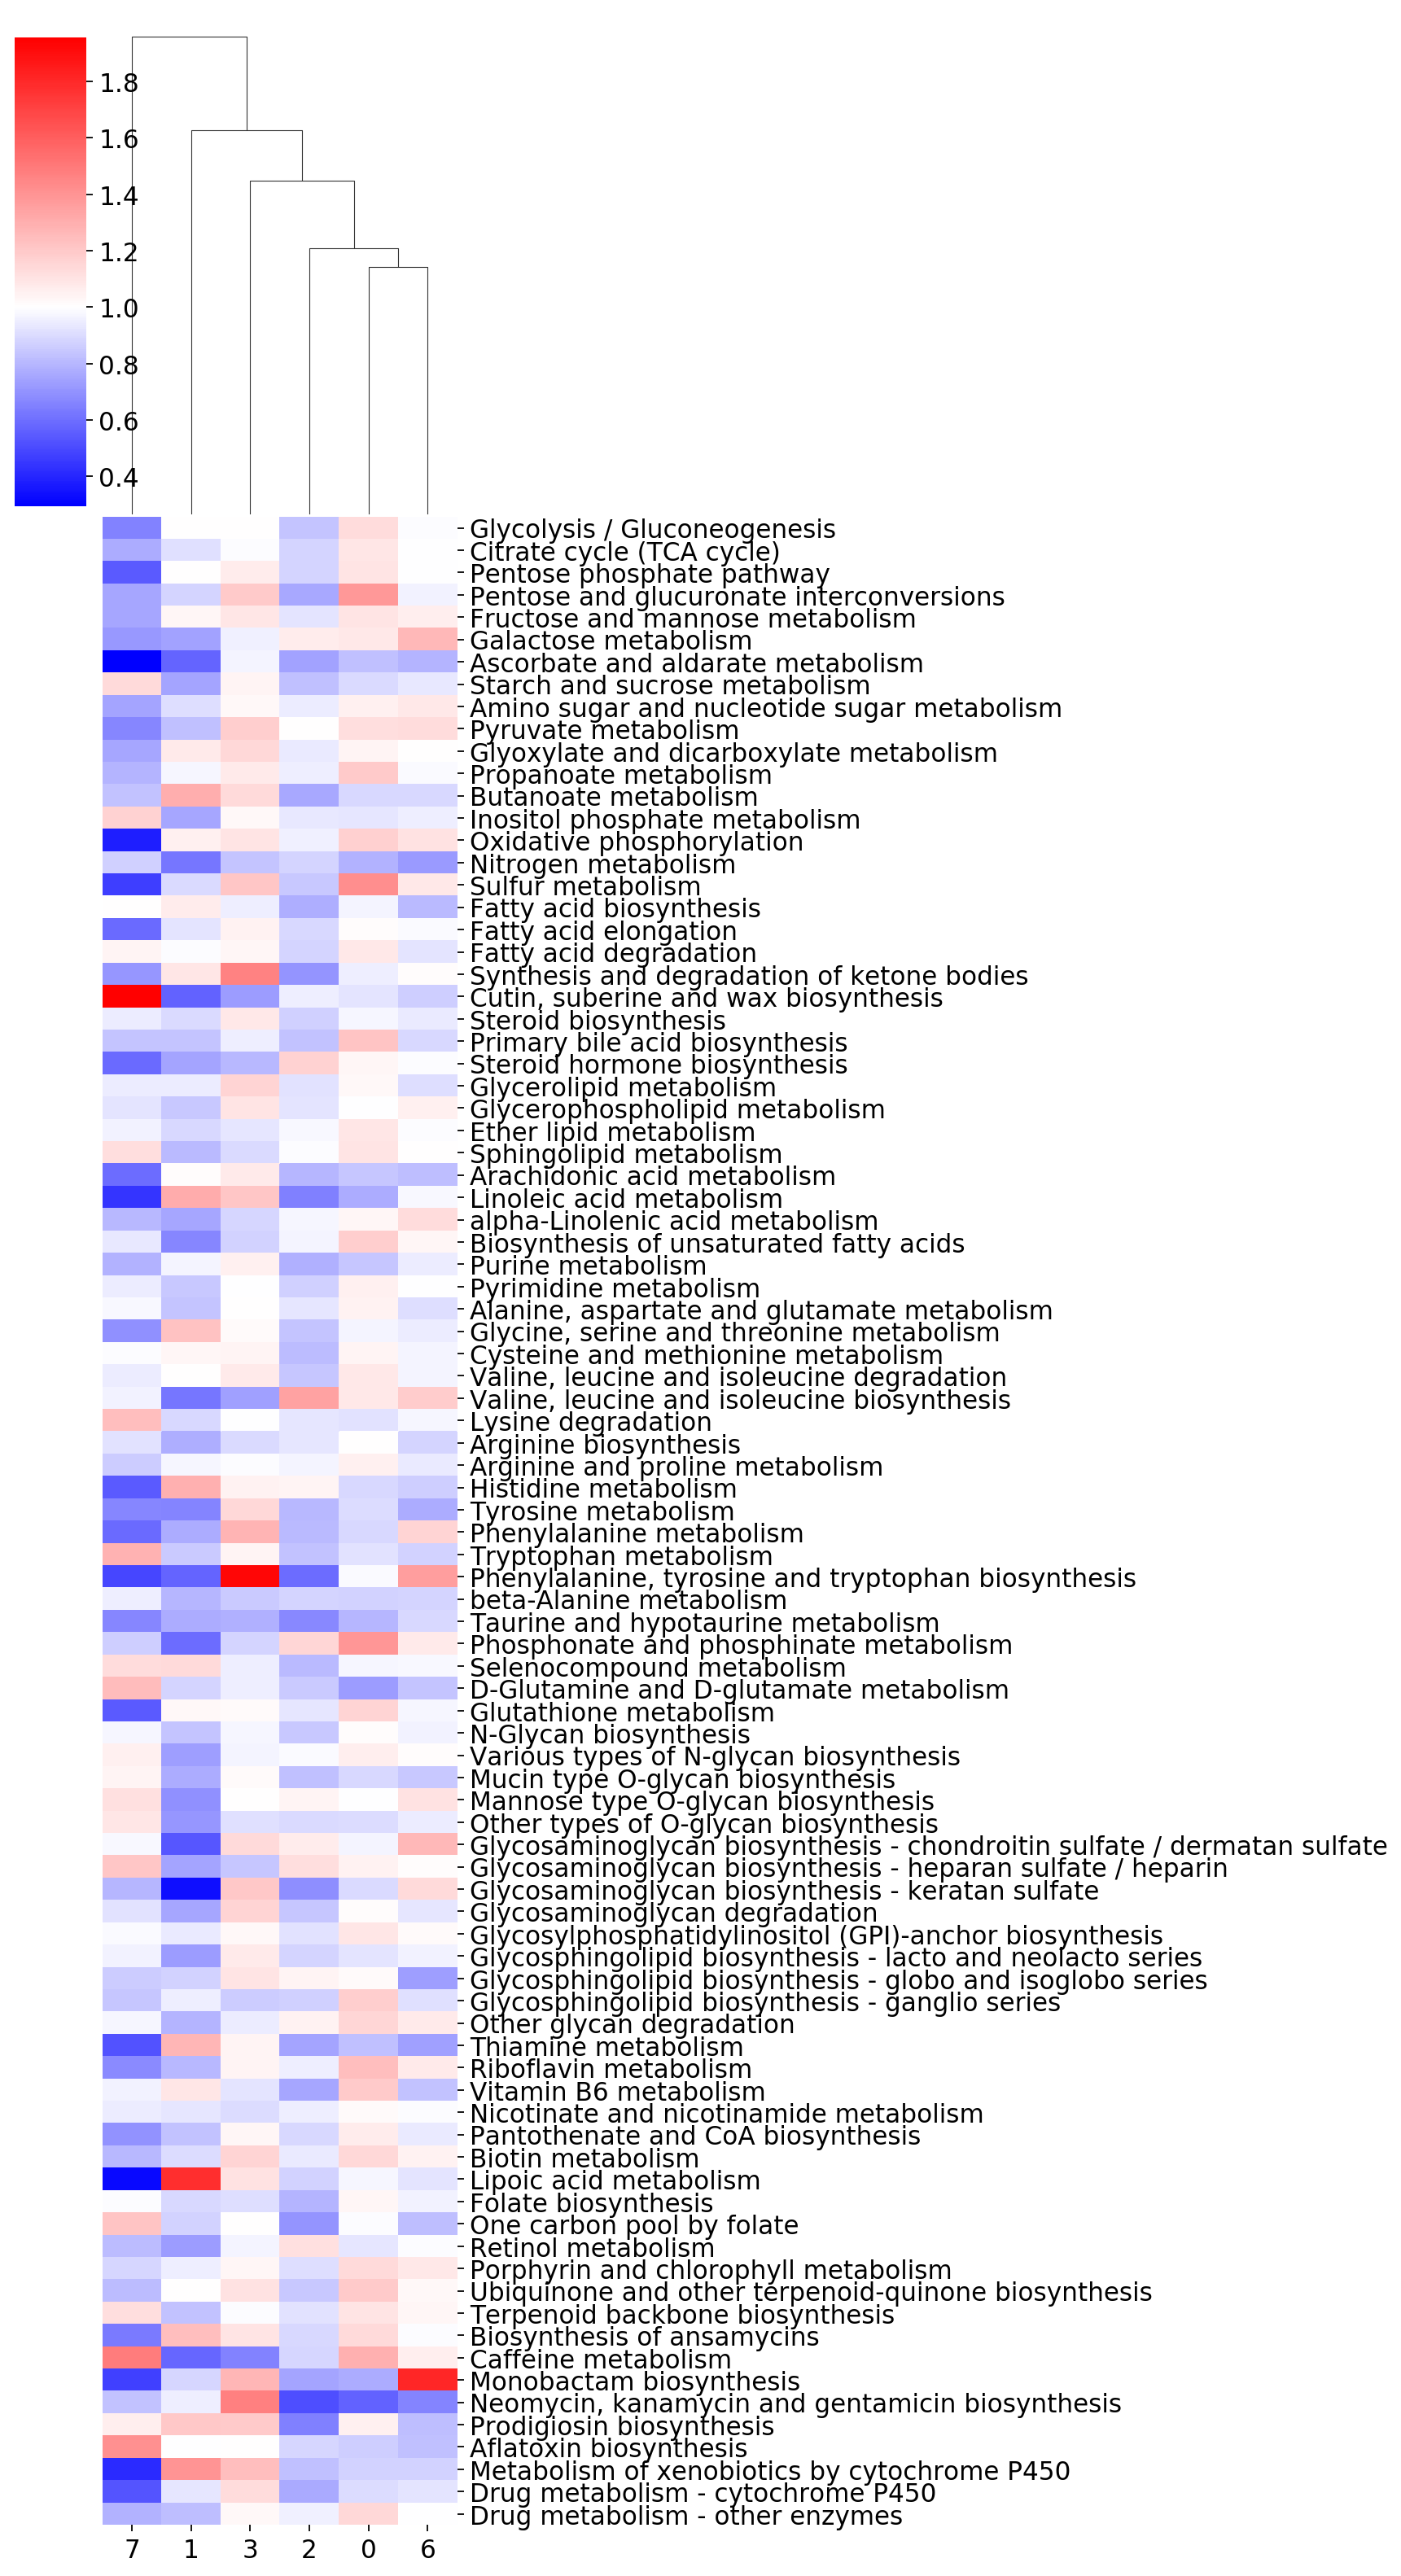

In [77]:
fig = sns.clustermap(p_ICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [78]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_ICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-ICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

### Analysis per patient

#### All cells

In [23]:
# Not using subpopulations here for now
p = pathway_activity(adata, adata_metab, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


<ipython-input-24-722fed5ff44e>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 91.5746527777778, '')

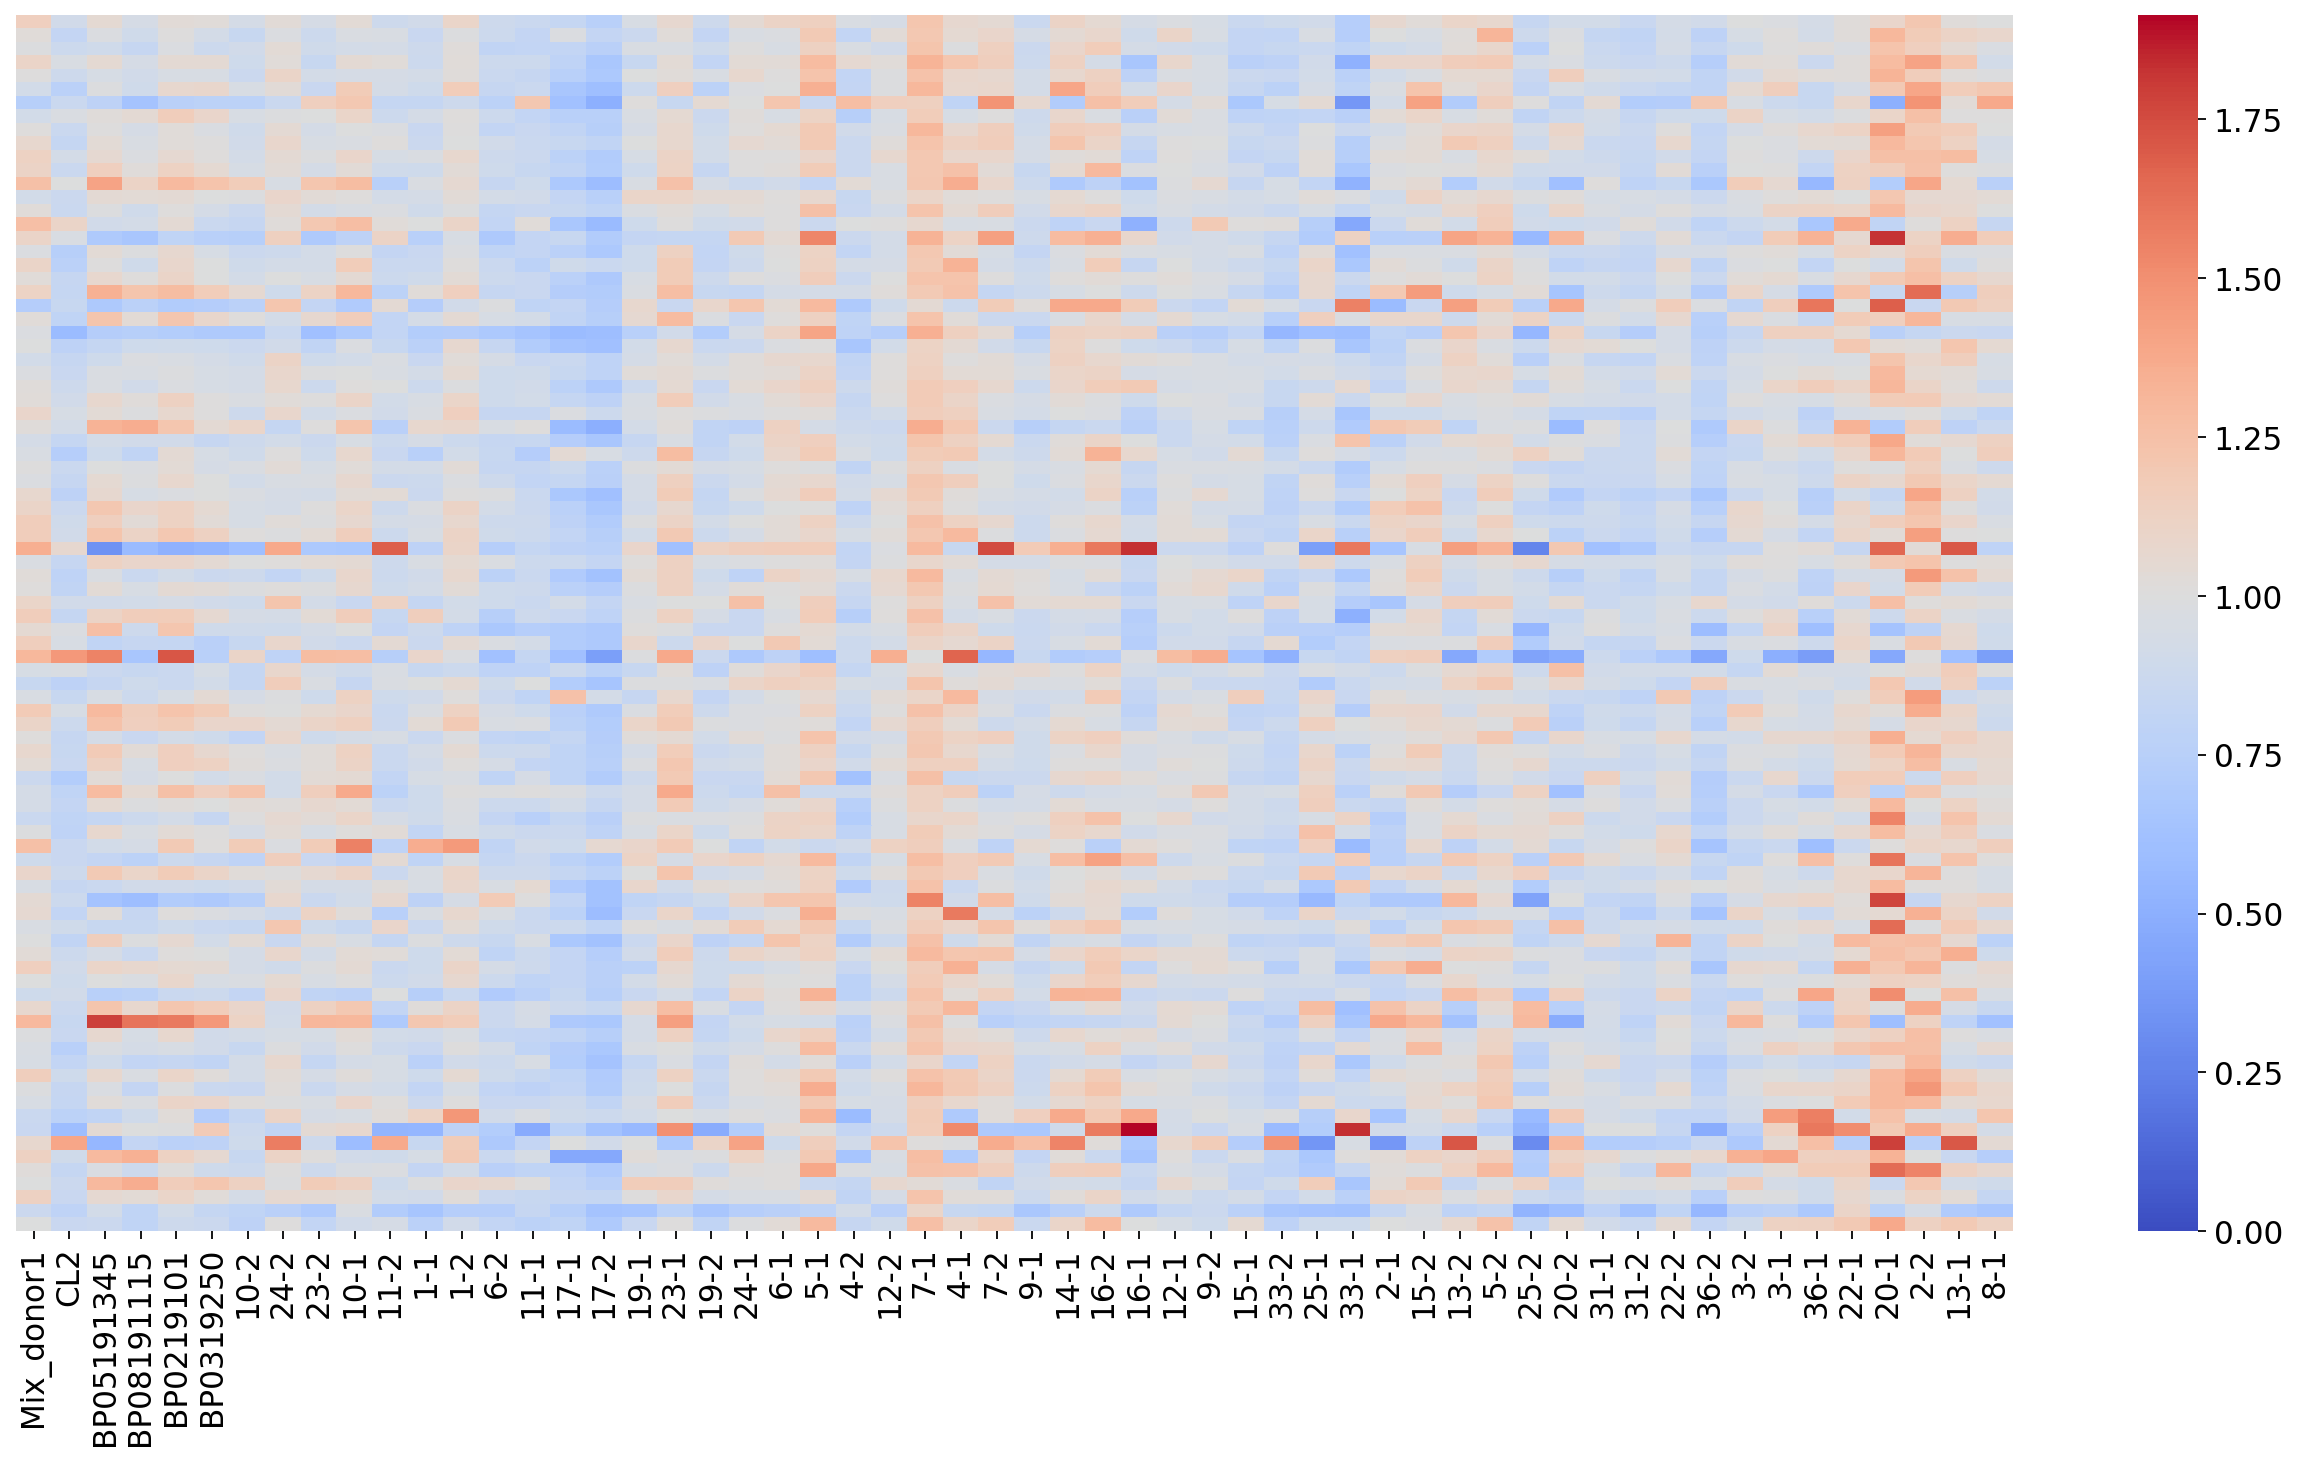

In [24]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [25]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['patient'])
    adata.obs['patient_shuffled'] = clusters_shuffled
    adata_metab.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900


<ipython-input-26-c9ef2c2fd1ea>:20: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 67.5746527777778, '')

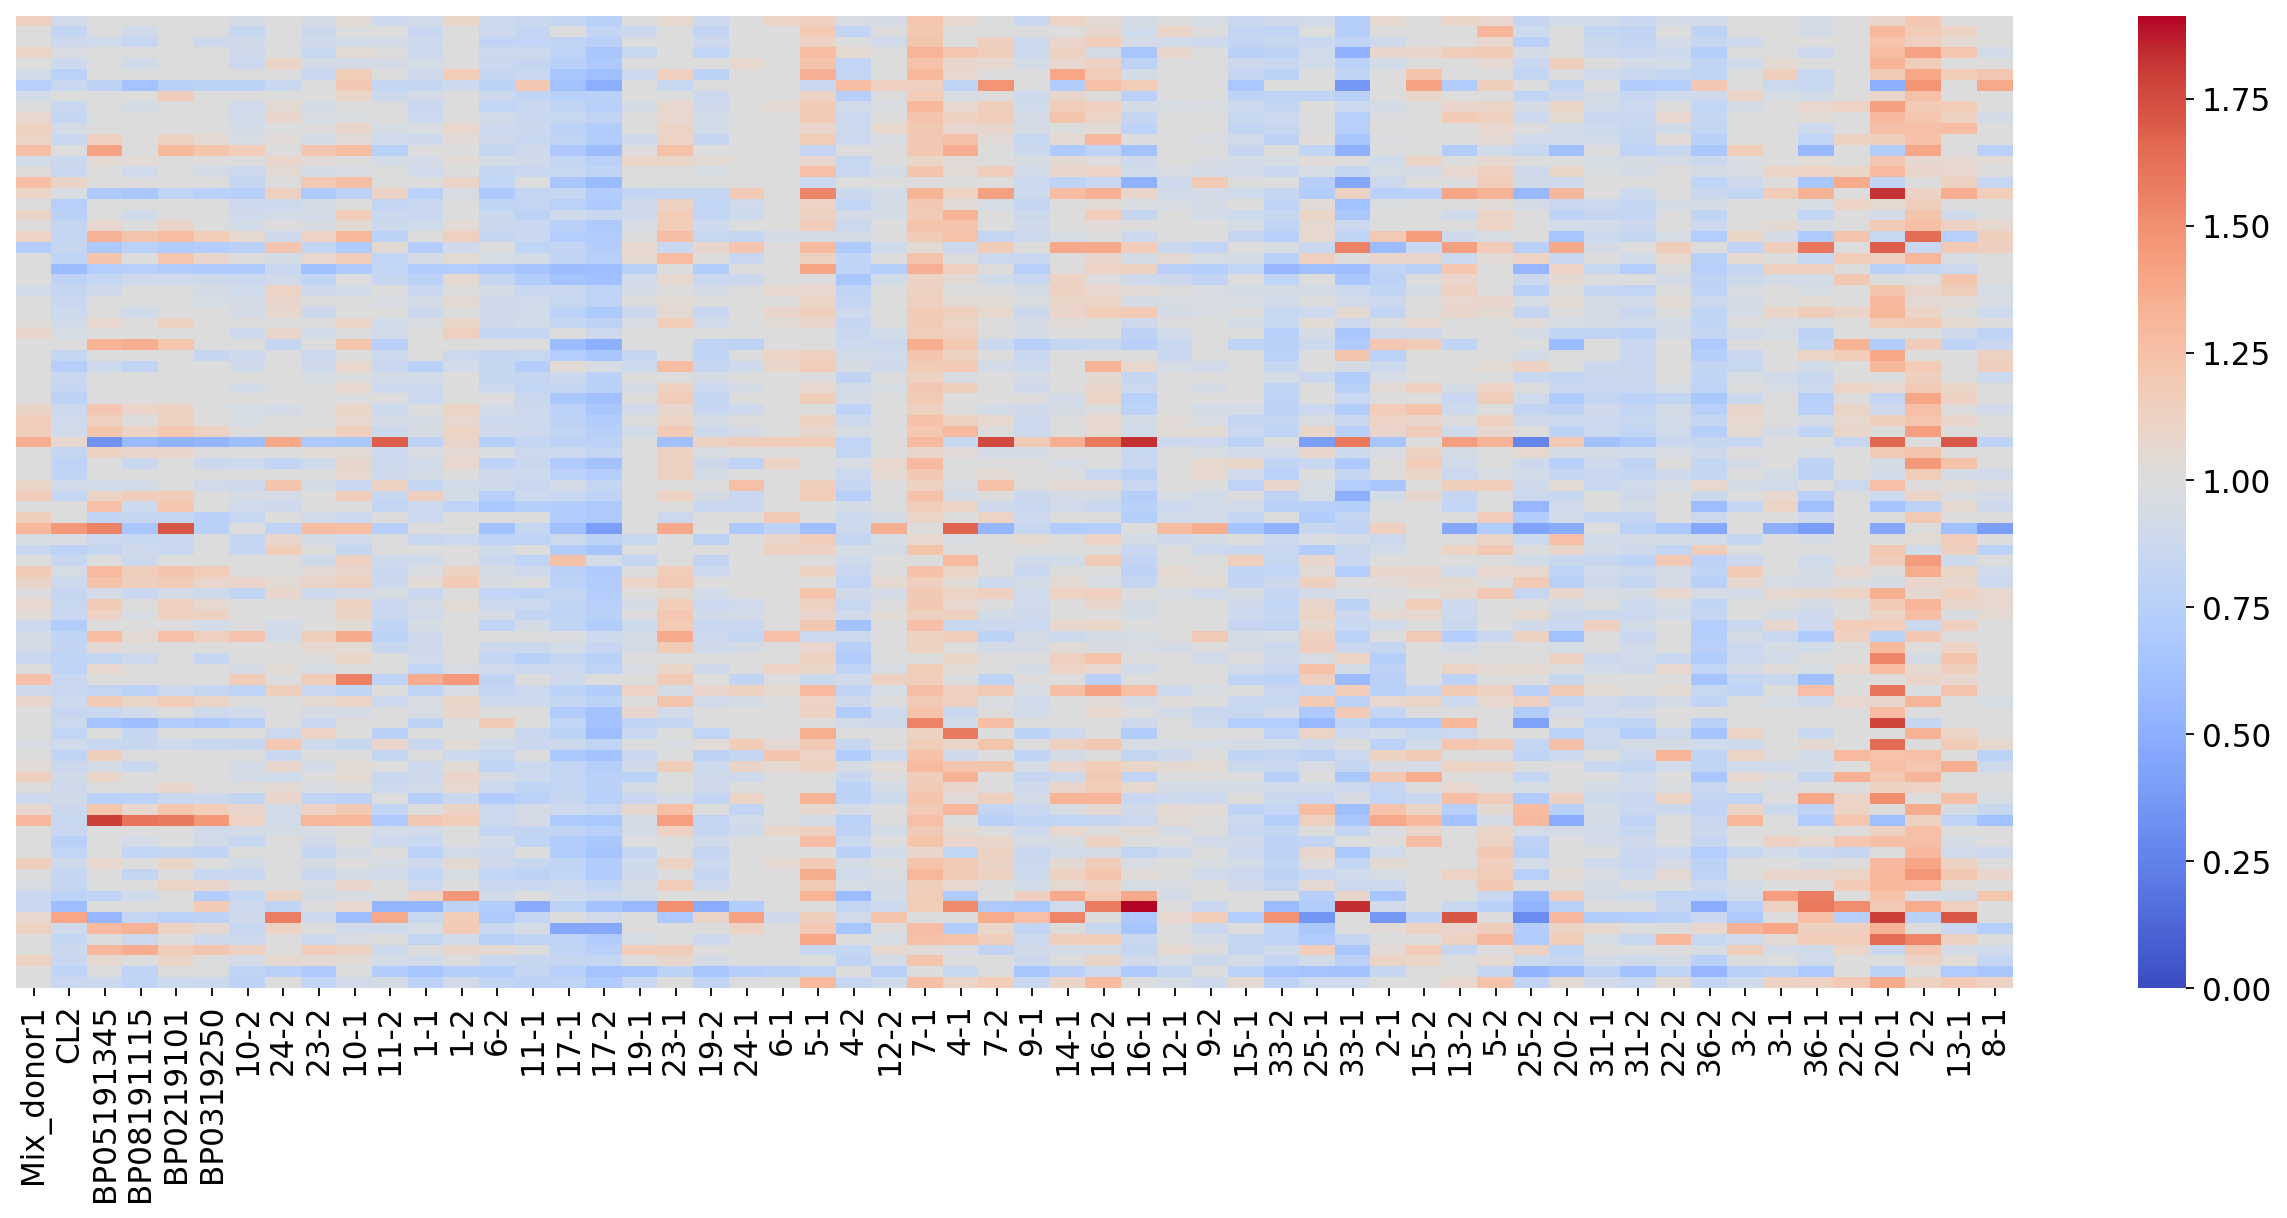

In [26]:
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None)

#df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 8))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

<Figure size 320x320 with 0 Axes>

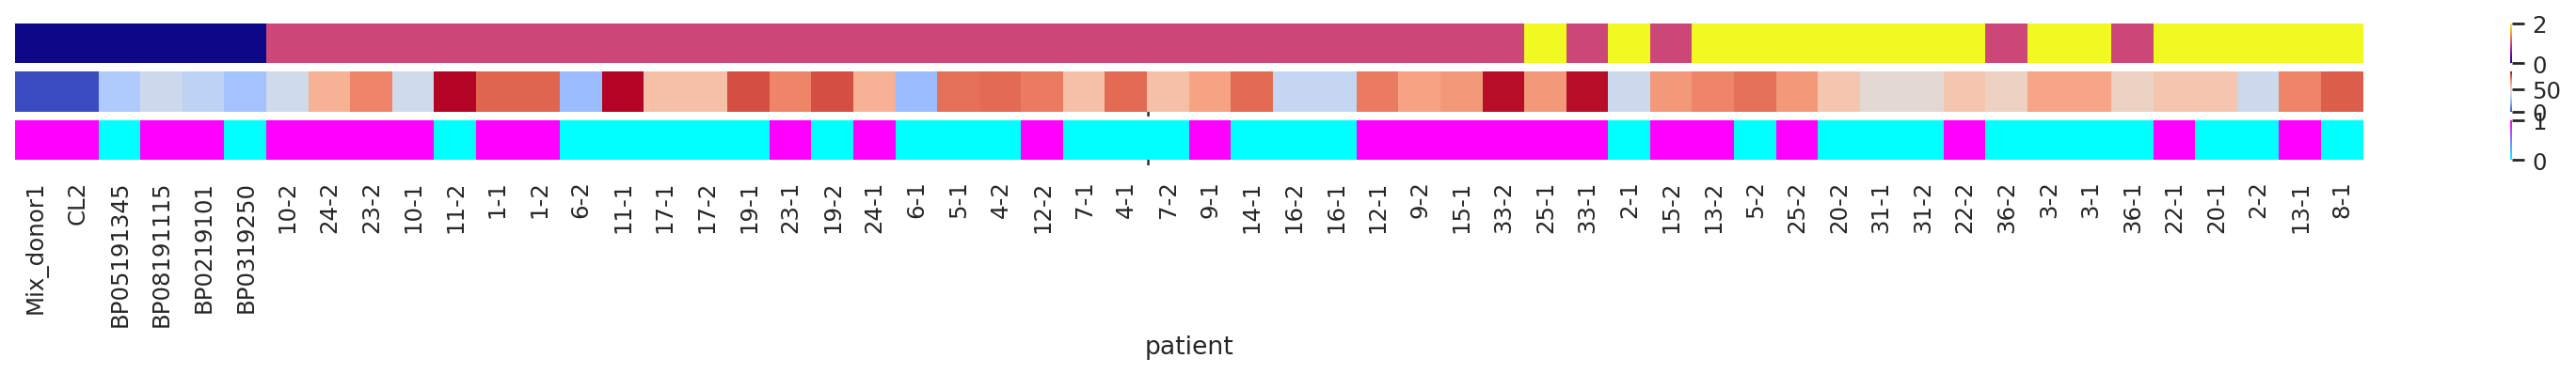

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

In [27]:
# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])

df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])

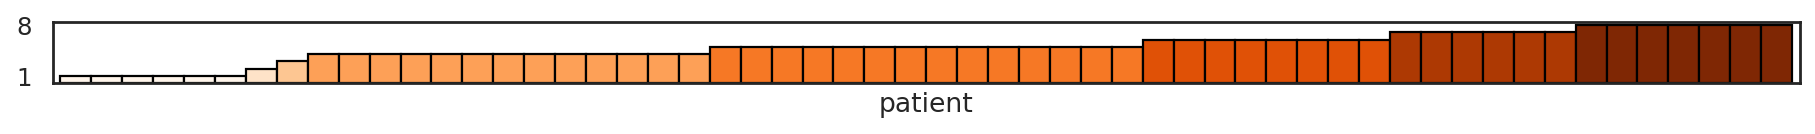

In [28]:
df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

#### Correlating pathway activity plotting functions

In [41]:
def plot_corresponding(df_all, sig_pathways, orig_adata, figsize=(15, 3), cmap='coolwarm'):
    # Plot the top corresponding ones
    df_p_corresponding = pd.DataFrame(df_all)
    df_p_corresponding.index = metab_genes.index
    patients = orig_adata.obs['patient'].unique().astype(str)
    patients.sort()
    df_p_corresponding.columns = patients

    patients_WHO = orig_adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
    #patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
    #patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
    #patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
    df_p_corresponding = df_p_corresponding.loc[sig_pathways.index, patients_WHO]

    # When plotting, sort by metabolic pathway group first, then by spearman r
    df_p_corresponding['category'] = df_p_corresponding.index.map(classifications)
    df_p_corresponding['Spearman'] = sig_pathways['Spearman']
    df_p_corresponding = df_p_corresponding.sort_values(by=['category', 'Spearman'], ascending=[True, False])
    print(df_p_corresponding['category'])
    df_p_corresponding = df_p_corresponding.drop(columns=['category', 'Spearman'])

    ax = plt.figure(figsize=figsize)
    ax = sns.heatmap(df_p_corresponding, cmap=cmap, yticklabels=[], vmin=0,
                         norm=DivergingNorm(1.0))
    #ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    return df_p_corresponding

def plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 3)):
    # Dot plot for the significant ones
    sns.set_style('white')
    sns.set_style('ticks')
    fig = plt.figure(figsize=figsize)
    fig = sns.scatterplot(x=np.zeros(len(sig_pathways)), y=np.arange(0, len(sig_pathways), 1)[::-1], 
                          hue='Spearman', size='-log10(p)', hue_order=np.arange(0, 0.5, 0.1), 
                          sizes=(10, 40), data=sig_pathways.loc[df_corresponding.index])
    fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=6)
    sns.despine()

In [ ]:
# For correlation, not using the statistically deleted values (need raw values)
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-all_cells' + '.csv')
sig_pathways

0
Phenylalanine, tyrosine and tryptophan biosynthesis                          Amino acid metabolism
Prodigiosin biosynthesis                               Biosynthesis of other secondary metabolites
Amino sugar and nucleotide sugar metabolism                                Carbohydrate metabolism
Butanoate metabolism                                                       Carbohydrate metabolism
Sulfur metabolism                                                                Energy metabolism
Oxidative phosphorylation                                                        Energy metabolism
Glycosaminoglycan degradation                                   Glycan biosynthesis and metabolism
Other glycan degradation                                        Glycan biosynthesis and metabolism
alpha-Linolenic acid metabolism                                                   Lipid metabolism
Cutin, suberine and wax biosynthesis                                              Lipid metabolism
Steroid 

<ipython-input-38-bfdb14604942>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


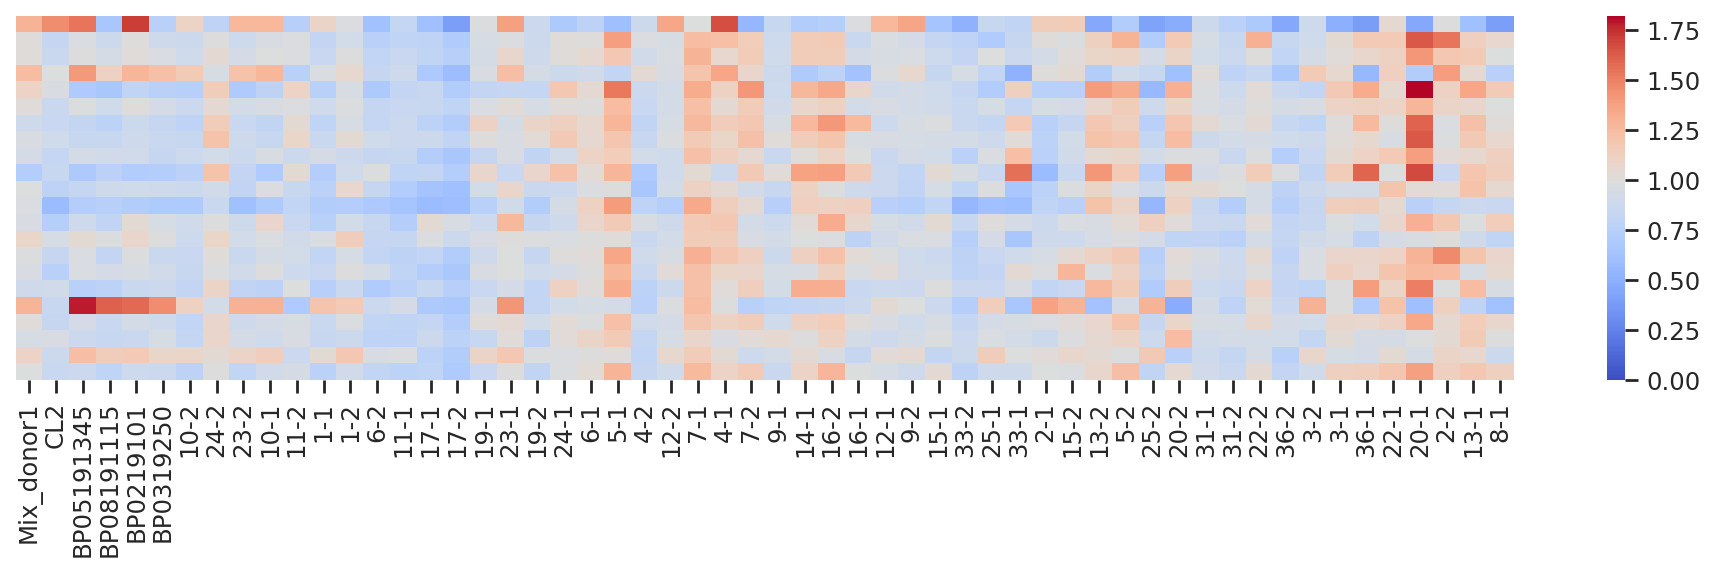

In [39]:
df_corresponding = plot_corresponding(p, sig_pathways, adata)

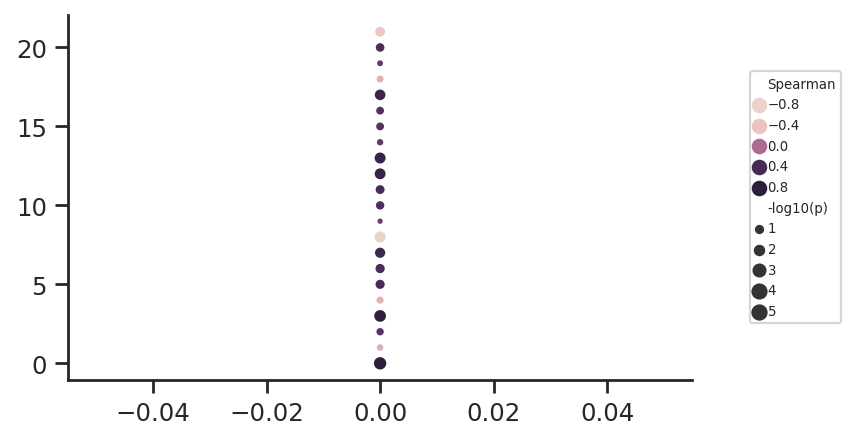

In [40]:
plot_spearman_dots(sig_pathways, df_corresponding)